In [2]:
import pandas as pd
import numpy as np
import nltk
import seaborn as sns
import time
import re
import random

# Initialisation du générateur de nombres aléatoires
random.seed(123)

tokenizer = nltk.RegexpTokenizer(r'''\w'|\w+|[^\w\s]''')

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Reshape, SpatialDropout1D
# from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [3]:
import nltk

# Télécharge les données nécessaires pour le tokenizer (segmenteur) de phrases et de mots
nltk.download('punkt')

# Télécharge la liste de mots vides (stopwords) pour différentes langues
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\samir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\samir\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
train_data = pd.read_csv('cleaned_data/train_cleaned.csv',index_col=0)
dev_data   = pd.read_csv('cleaned_data/dev_cleaned.csv',index_col=0)
test_data  =  pd.read_csv('cleaned_data/test_cleaned.csv',index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: 'cleaned_data/train_cleaned.csv'

In [4]:
print("train_data shape",train_data.shape)
print("dev_data shape",dev_data.shape)
print("test_data shape",test_data.shape)

train_data shape (665962, 6)
dev_data shape (100400, 6)
test_data shape (85847, 5)


In [5]:
# GET ONLY 1/4 OF TRAIN AND DEV DATA DUE TO COMPUTATION RESOURCES LIMITATIONS
# train_data = train_data.head(166490)
# dev_data = dev_data.head(25100)


In [6]:
train_data

,movie,review_id,name,user_id,note,commentaire
0,229864,review_58145147,AM11,Z20051105131449940367618,7,trouve face tient côté cette phrase tagline fi...
1,229864,review_59303833,this is my movies,Z20051220181957240298347,6,soi rien contre genre récit hyper codifié déjà...
2,229864,review_61916672,Shephard69,Z20121226180301760912584,8,troisième réalisation après tron héritage obli...
3,229864,review_1000190786,Tayop,Z20121022182542230468657,5,joseph kosinski offre nouvelles images ébourif...
4,229864,review_59207755,ned123,Z20061211223247607682175,6,film traite drame humain plus haute intensité ...
...,...,...,...,...,...,...
665957,245551,review_55820729,Wally L,Z20121109004006553333277,7,super realisation quelques bon acteurs cette v...
665958,245551,review_1001840194,r@ch,Z20100726110927837577369,5,film visuellement très beau mis musique rap am...
665959,245551,review_56242470,Kaiser D.,Z20170721223303710182536,6,parti histoire parait banale très bon film tou...
665960,245551,review_58174196,Florent A.,Z20161204004443590736237,5,mitigé film coté plutot accroché peu mal aise ...


In [7]:
train_data['commentaire'] = train_data['commentaire'].astype(str)
dev_data['commentaire'] = dev_data['commentaire'].astype(str)
test_data['commentaire'] = test_data['commentaire'].astype(str)

# Data Split

In [8]:
X_train = train_data['commentaire']
X_dev = dev_data['commentaire']
X_test = test_data['commentaire']

y_train = train_data['note']
y_dev = dev_data['note']

In [9]:
y_train

0         7
1         6
2         8
3         5
4         6
         ..
665957    7
665958    5
665959    6
665960    5
665961    6
Name: note, Length: 665962, dtype: int64

# Y one hot encoding

In [10]:
y_train_one_hotencoding = to_categorical(y_train, num_classes=10)
print(y_train_one_hotencoding[:10])

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]]


In [11]:
y_dev_one_hotencoding = to_categorical(y_dev, num_classes=10)
print(y_dev_one_hotencoding[:10])

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [12]:
len(list(X_train.unique()))

664548

# Tokenization

In [13]:
n_most_common_words = 10000
max_len = 180

tokenizer = Tokenizer(num_words=n_most_common_words)
tokenizer.fit_on_texts(list(X_train))

X_train = tokenizer.texts_to_sequences(X_train) 
X_dev = tokenizer.texts_to_sequences(X_dev)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


X_train = pad_sequences(X_train, maxlen=max_len)
X_dev = pad_sequences(X_dev, maxlen=max_len)

Found 230161 unique tokens.


# Training

In [14]:
epochs  = 5
emb_dim = 128
# batch_size = 32
batch_size = 128

In [15]:
print((X_train.shape, y_train_one_hotencoding.shape, X_dev.shape, y_dev_one_hotencoding.shape))


((665962, 180), (665962, 10), (100400, 180), (100400, 10))


In [16]:
# Model definition
model = Sequential()
model.add(Embedding(n_most_common_words, emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2, return_sequences=False))

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Create callbacks
filepath = 'Lstm_best_model.hdf5'
checkpoint = ModelCheckpoint(
    filepath=filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,  # Increased patience
    restore_best_weights=True
)

callbacks = [checkpoint, early_stopping]

# Training
start_time = time.time()
history = model.fit(X_train, y_train_one_hotencoding, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_dev, y_dev_one_hotencoding), verbose=1, callbacks=callbacks)
execution_time = time.time() - start_time

print('Execution time:', time.strftime("%H:%M:%S", time.gmtime(execution_time)))

2024-01-03 22:33:44.244475: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 180, 128)          1280000   
                                                                 
 lstm (LSTM)                 (None, 180, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 180, 256)          394240    
                                                                 
 lstm_2 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2

/home/ec2-user/anaconda3/envs/tensorflow2_p310/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


5203/5203 [==============================] - ETA: 0s - loss: 1.4901 - accuracy: 0.3958
Epoch 2: val_accuracy improved from 0.38625 to 0.39970, saving model to Lstm_best_model.hdf5
5203/5203 [==============================] - 5510s 1s/step - loss: 1.4901 - accuracy: 0.3958 - val_loss: 1.4848 - val_accuracy: 0.3997
Epoch 3/5
5203/5203 [==============================] - ETA: 0s - loss: 1.4508 - accuracy: 0.4096
Epoch 3: val_accuracy improved from 0.39970 to 0.40268, saving model to Lstm_best_model.hdf5
5203/5203 [==============================] - 4438s 853ms/step - loss: 1.4508 - accuracy: 0.4096 - val_loss: 1.4801 - val_accuracy: 0.4027
Epoch 4/5
5203/5203 [==============================] - ETA: 0s - loss: 1.4226 - accuracy: 0.4189
Epoch 4: val_accuracy improved from 0.40268 to 0.40445, saving model to Lstm_best_model.hdf5
5203/5203 [==============================] - 4224s 812ms/step - loss: 1.4226 - accuracy: 0.4189 - val_loss: 1.4833 - val_accuracy: 0.4045
Epoch 5/5
5203/5203 [========

# save train and validation accuracy/loss

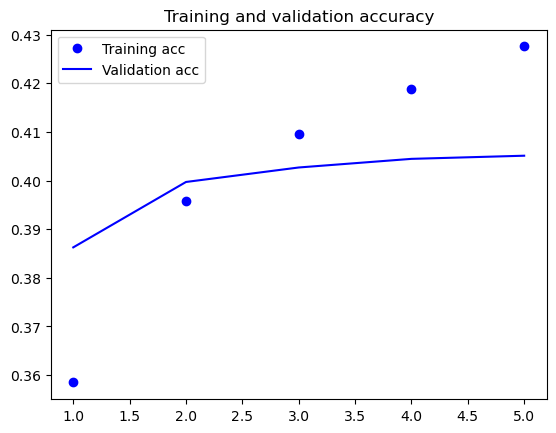

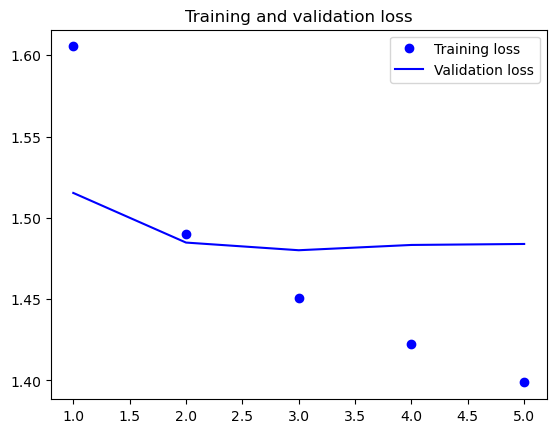

In [17]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot accuracy
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.savefig('accuracy_plot.png')  # Save the plot as an image

# Clear the figure for the next plot
plt.figure()

# Plot loss
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.savefig('loss_plot.png')  # Save the plot as an image


# Test and saving results

In [1]:
from tensorflow.keras.models import load_model

# model = load_model('MLP_Best_One.hdf5'),this command doesn't work for me, i had to change the saved model path

modelpath = "C:/trained_Models/Lstm_best_model.hdf5"

# Load the model with compile=False
Lstm_best_model = load_model(modelpath)

X_test = test_data['commentaire']
X_test = tokenizer.texts_to_sequences(X_test)
X_test = pad_sequences(X_test, maxlen=max_len)

predictions = Lstm_best_model.predict(X_test)
argmax_predictions = np.argmax(predictions,axis =1)

print("argmax_predictions: ",argmax_predictions)
 
# # generate the plateform test data format        
with open("LSTM_ID_Prediction_improved.txt", "w") as f:
    for i in range(len(test_data['review_id'])):
        prediction = (argmax_predictions[i] + 1) / 2
        line = f"{test_data['review_id'].iloc[i]} {str(prediction).replace('.', ',')}\n"
        f.write(line)

      

NameError: name 'test_data' is not defined